In [36]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

files = glob.glob("../hku-data/test_data/*.csv")
data_list = []

for f in files:
    df = pd.read_csv(f)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['symbol'] = os.path.basename(f).replace('.csv','')
    data_list.append(df)

data = pd.concat(data_list)
data = data.drop_duplicates(subset=['timestamp', 'symbol'])
data.sort_values(by=['timestamp', 'symbol'], inplace=True)

n = 20
data['return'] = data.groupby('symbol')['close'].pct_change(n)

In [39]:
def cross_section_rank(group):
    group = group.copy()
    group['cs_rank'] = group['return'].rank(pct=True)
    if group['volume'].std() > 0:
        vol_scaled = (group['volume'] - group['volume'].mean()) / group['volume'].std()
    else:
        vol_scaled = 0
    group['enhanced_mom'] = (group['cs_rank'] - 0.5) * (1 + 0.1 * vol_scaled)
    return group

data = data.groupby('timestamp', group_keys=False).apply(cross_section_rank)
data = data.reset_index(drop=True)

top_threshold = 0.4
bottom_threshold = -0.4
data['signal'] = 0
data.loc[data['enhanced_mom'] > top_threshold, 'signal'] = 1
data.loc[data['enhanced_mom'] < bottom_threshold, 'signal'] = -1

data.to_csv("cross_section_enhanced_momentum_signals.csv", index=False)

C:\Users\flebe\AppData\Local\Temp\ipykernel_8984\4006370710.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('timestamp', group_keys=False).apply(cross_section_rank)


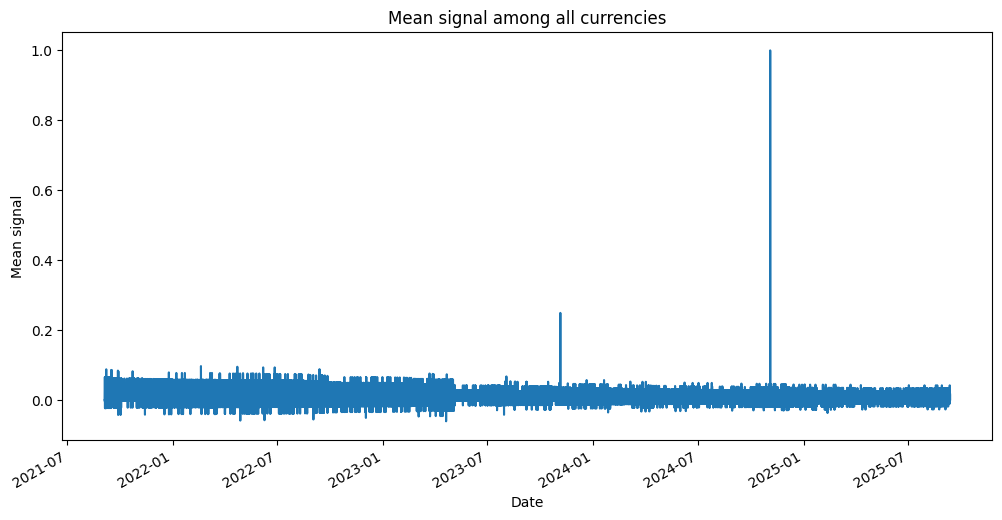

In [45]:
plt.figure(figsize=(12,6))
data.groupby('timestamp')['signal'].mean().plot(title="Mean signal among all currencies")
plt.xlabel("Date")
plt.ylabel("Mean signal")
plt.show()